<h3>Discover the best math grades of ENEM 2016<br></h3>

You must create a model to predict the math test grade for those who participated in ENEM 2016. For this you will use Python, Pandas, Sklearn and Regression.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sys

from sklearn.linear_model import LinearRegression

# could not manage to use a package version of refactor modules
sys.path.insert(0, '../src')
import send_answer

# expand the amount of displayed columns in pandas
pd.set_option('display.max_columns', 500)

%matplotlib inline

In [2]:
# input data
train = pd.read_csv('../data/raw/train.csv', index_col=0).set_index('NU_INSCRICAO')
test = pd.read_csv('../data/raw/test2.csv').set_index('NU_INSCRICAO')

It's relevant to point that we want to predict the grades of the ones that actually were present on the day of the Math test. However, math attendance (`TP_PRESENCA_MT`) is not contained in the test set.

Despite that, can we assume that the ones that missed the Languages and Codes (`TP_PRESENCA_LC`) test also missed the Math test. <br>So we can safely drop the entries where `TP_PRESENCA_LC` is equal to 0

In [3]:
print("Train set features: {}".format(list(train.columns[train.columns.str.contains('TP_PRESENCA')])))
print("Test set features: {}\n".format(list(test.columns[test.columns.str.contains('TP_PRESENCA')])))

list(train[['TP_PRESENCA_LC','TP_PRESENCA_MT']].sum(axis=1).unique())

Train set features: ['TP_PRESENCA_CN', 'TP_PRESENCA_CH', 'TP_PRESENCA_LC', 'TP_PRESENCA_MT']
Test set features: ['TP_PRESENCA_CN', 'TP_PRESENCA_CH', 'TP_PRESENCA_LC']



[0.0, 2.0, 4.0]

<h3>Missing data percentage</h3><br>
By ranking the fields with most missing data we can see three fields presenting a very high percentage of missing values, therefore will be later dropped.

In [4]:
train_only_presents = train.loc[train.TP_PRESENCA_LC == 1, test.columns]
total = train_only_presents.isnull().sum()
percentage = total/len(train_only_presents)
pd.concat([total, percentage], axis=1, keys=['Total', 'Percentage']).nlargest(6,'Total')

,Total,Percentage
TP_ENSINO,7046,0.710640
TP_DEPENDENCIA_ADM_ESC,7046,0.710640
Q027,5004,0.504690
NU_NOTA_CN,43,0.004337
NU_NOTA_CH,43,0.004337
CO_UF_RESIDENCIA,0,0.000000


<h3>Feature amalgamation</h3><br>

By analyzing the features variation in relation to the target we can try to make some sense of the important and unimportant factors as well as figure ways to split/merge categories to increase the model's accuracy.

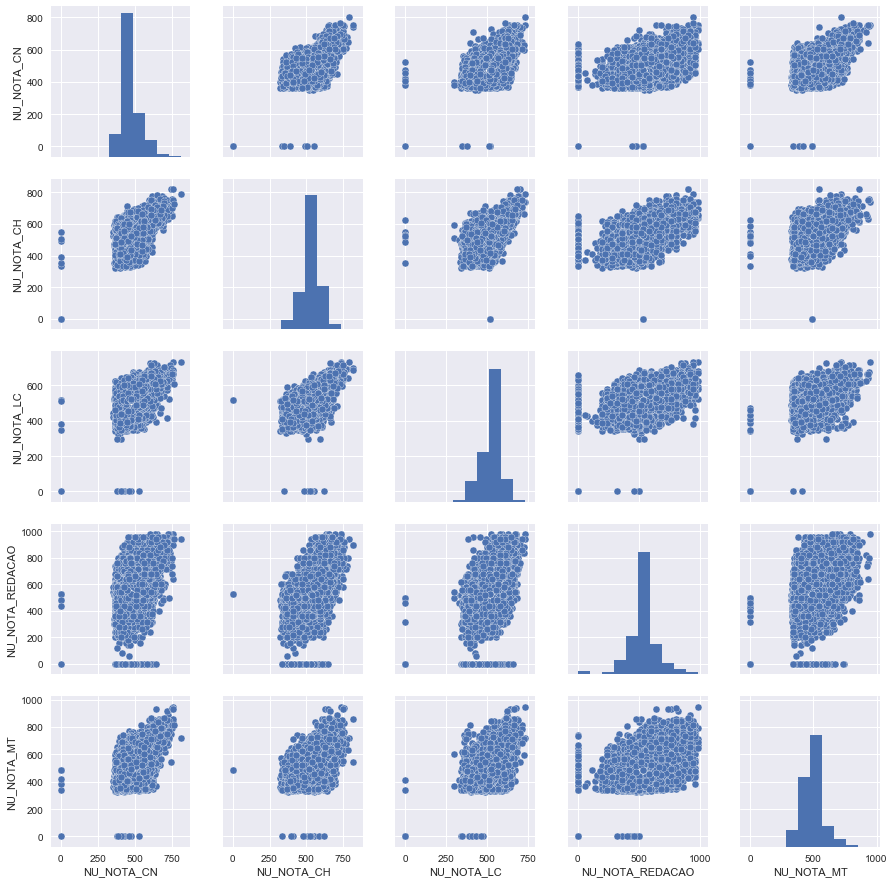

In [5]:
# pair plots
sns.set()
plot_set = train.copy().loc[:,['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC','NU_NOTA_REDACAO','NU_NOTA_MT']]
plot_set = plot_set.fillna(plot_set.mean())
sns.pairplot(plot_set)
plt.show();

C:\Users\Artur\Anaconda3\lib\site-packages\seaborn\categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


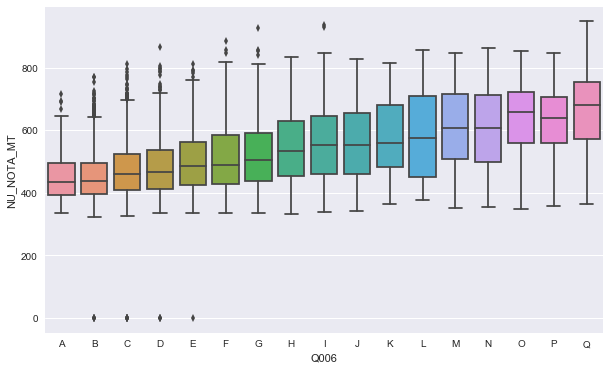

In [6]:
# box plot
var = 'Q006'
data = pd.concat([train['NU_NOTA_MT'], train[var]], axis=1).sort_values(var)
f, ax = plt.subplots(figsize=(10, 6))
fig = sns.boxplot(x=var, y="NU_NOTA_MT", data=data)

Below, the images show some of the categorical unions in features

<p>
    ``TP_STATUS_REDACAO``
    <br>
    <img src="../reports/figures/redacao.png" align="left"/>
</p>

<p style="clear:both">
    <br>
    ``Q001: Até que série seu pai, ou o homem responsável por você, estudou?``
    <br>
    ``Q002: Até que série sua mãe, ou a mulher responsável por você, estudou?``
    <img src="../reports/figures/q1q2.png" align="left"/>
</p>

<p style="clear:both">
    <br>
    ``Q006: Qual é a renda mensal de sua família? (Some a sua renda com a dos seus familiares.)``
    <img src="../reports/figures/q6.png" align="left"/>
</p>


<p style="clear:both">
    <br>
    ``Q024: Na sua residência tem computador?``<br>
    <img src="../reports/figures/q24.png" align="left"/>
</p>










In [7]:
def transform_dataset(dataset):
        
    df = dataset.copy(deep=True)
    
    # Transform irregularities in a single label(0)
    TP_columns = list(df.columns[df.columns.str.contains('PRESENCA')])
    df.loc[:, TP_columns] = (df.loc[:, TP_columns]
                               .astype(str)
                               .replace(r'^(?!1.0).*$', value=0, regex=True)
                               .astype(float))

    # Fill the unexisting values in the continuous fields (NU) with their average
    NU_columns = list(df.columns[df.columns.str.startswith('NU')])
    df.loc[:, NU_columns] = df.loc[:, NU_columns].fillna(df.loc[:, NU_columns].mean())
    
    # Transform 'state' feature in 'region'
    regioes = {
        'N': ['AC', 'AM', 'AP', 'PA', 'RO', 'RR', 'TO'],
        'NE': ['AL', 'BA', 'CE', 'MA', 'PB', 'PE', 'PI', 'RN', 'SE'],
        'CE': ['GO', 'MS', 'MT'],
        'SE': ['SP', 'ES', 'RJ', 'MG'],
        'S': ['PR', 'SC', 'RS']
    }
    
    for reg in regioes:
        df.loc[df.SG_UF_RESIDENCIA.isin(regioes[reg]), 'SG_UF_RESIDENCIA'] = reg
    
    # Essay status - reduce to 3: Writing problems
    df.loc[~df['TP_STATUS_REDACAO'].isin([1, 4]), 'TP_STATUS_REDACAO'] = 3
    
    # Merge fields from Q001 and Q002
    to_replace = {
        'C': 'B',
        'E': 'D'
    }
    df.loc[:, ['Q001', 'Q002']].replace(to_replace, inplace=True)
    
    # Merge Q006 fields
    to_replace = {
        'C': 'B',
        'H': 'G',
        'I': 'G',
        'E': 'D',
        'F': 'D',
        'K': 'J',
        'L': 'J',
        'M': 'J',
        'O': 'N',
        'P': 'N'
    }
    df['Q006'].replace(to_replace, inplace=True)
    
    # Merge Q024 fields
    to_replace = {
        'D': 'C',
        'E': 'C'
    }
    df['Q024'].replace(to_replace, inplace=True)
    
    return df

In [8]:
def clean_dataset(dataset, columns):
    
    df = dataset.copy(deep=True)
    
    # We're interessed in predicting only the ones that completed the test
    df = df[df.TP_PRESENCA_LC == 1.0]
    
    # if the dataset to clean is the training set then remove the unexisting columns in the test set
    
    key = 'NU_NOTA_MT'
    if key not in df.columns:
        df[key] = 0
    else:
        df = df.loc[df.NU_NOTA_MT != 0]
    df = df.loc[:, list(columns)+[key]]
    
    # the fields below were judged redundant or badly distributed
    to_remove = ['CO_UF_RESIDENCIA', 
                 'TP_ANO_CONCLUIU',
                 'CO_PROVA_CN', 'CO_PROVA_CH', 'CO_PROVA_LC', 'CO_PROVA_MT',
                 'TP_DEPENDENCIA_ADM_ESC', 
                 'TP_ENSINO', 
                 'Q027']
    
    # remove TP_ESCOLA - very similar to Q047
    to_remove.append('TP_ESCOLA')
    # to_remove.append('Q047')
    
    # remove the considated essay grade, since its componenents are also in the dataset
    to_remove.extend(['NU_NOTA_REDACAO'])
    #to_remove.extend(['NU_NOTA_COMP1', 'NU_NOTA_COMP2', 'NU_NOTA_COMP3', 'NU_NOTA_COMP4', 'NU_NOTA_COMP5'])
    
    # remove the special indicators due to very uneven distribution
    to_remove.extend(list(df.columns[df.columns.str.startswith('IN')]))
    
    # drop all 'to_remove' columns
    df.drop(to_remove, axis=1, inplace=True)
    
    # drop unexpected columns with single values
    try:
        singular_columns = df.columns[list(map(lambda x: len(df[x].unique()) == 1, list(df.columns)[:-1]))]
        df.drop(singular_columns, axis=1, inplace=True)
    except IndexError:
        pass
    
    # transform the non-continuous fields in category data-types
    for i in list(df.columns[~df.columns.str.startswith('NU')]):
        df[i].astype('category')
    
    return df

In [9]:
def one_hot_dataset(dataset):
    
    # select only categorical columns
    one_hot_columns = list(dataset.columns[~dataset.columns.str.startswith('NU')])
    
    # apply one hot encoding to the dataset
    df = pd.get_dummies(dataset, columns=one_hot_columns)
    
    # move the target column to the last place
    target = df.columns.get_loc('NU_NOTA_MT')
    columns = list(df.columns.values)
    df = df.loc[:, columns[:target]+columns[target+1:]+[columns[target]]]

    return df

In [10]:
def plot_dist(target):
    
    from scipy import stats
    
    # histogram and normal probability plot
    try:
        to_analyse = target.reset_index(drop=True)
    except AttributeError:
        to_analyse = target
    
    sns.distplot(to_analyse, fit=stats.norm)
    fig = plt.figure()
    res = stats.probplot(to_analyse, plot=plt)

In [11]:
columns = test.columns

train_set = one_hot_dataset(transform_dataset(clean_dataset(train, columns)))
test_set = one_hot_dataset(transform_dataset(clean_dataset(test, columns)))

answer = test.loc[:,[]]
answer['NU_NOTA_MT'] = 0

missing_fields = list(set(train_set.columns) -set(test_set.columns)) +list(set(test_set.columns) -set(train_set.columns))

train_set.drop(missing_fields, axis=1, errors='ignore', inplace=True)
test_set.drop(missing_fields, axis=1, errors='ignore', inplace=True)

With a now cleaned and formatted dataset we can evaluate a prediction performance by employing a model and analyzing its R², the proportion of the variance in the dependent variable that is predictable from the independent variable(s).

MAPE: 0.1244


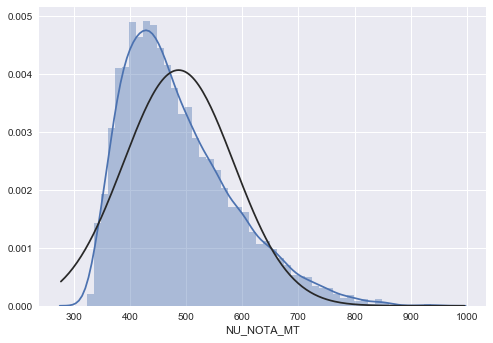

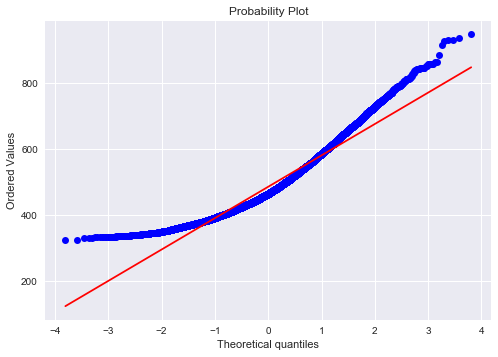

In [12]:
# MAPE: Mean absolute percentage error
mape = lambda y_true, y_pred: (abs(y_true-y_pred)/y_true).mean()

train_X = train_set.iloc[:,:-1]
train_Y = train_set.iloc[:,-1]

test_X = test_set.iloc[:,:-1]
test_Y = test_set.iloc[:,-1]

model_lin = LinearRegression(normalize=True)
model_lin = model_lin.fit(X=train_X, y=train_Y)
print('MAPE: %.4f'%mape(y_true=train_Y, y_pred=model_lin.predict(train_X)))
plot_dist(train_set.NU_NOTA_MT)


answer_lin = answer.copy()
answer_lin.loc[test_X.index, 'NU_NOTA_MT'] = model_lin.predict(X=test_X)
answer_lin = answer_lin.sort_values(by='NU_NOTA_MT',ascending=False).reset_index()

# New app not configured
# send_answer(answer_lin, 2)

We can increase its performance by analizing and transforming the behaviour of the input data

<h3>Normalization and linearization attempt</h3>

<a href="https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python">_Comprehensive data exploration with python_</a>


MAPE: 0.1211


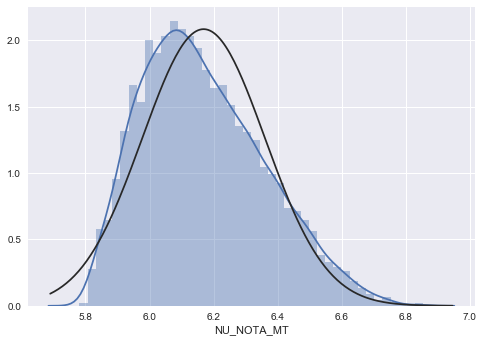

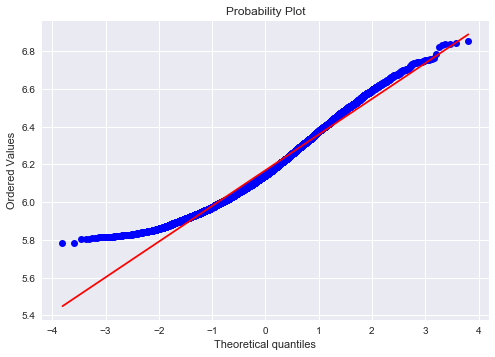

In [13]:
Y = np.log(train_Y)
plot_dist(Y)
model_log = LinearRegression(normalize=True)
model_log = model_log.fit(X=train_X, y=Y)
print('MAPE: %.4f'%mape(y_true=train_Y, y_pred=np.exp(model_log.predict(train_X))))

answer_log = answer.copy()
answer_log.loc[test_X.index, 'NU_NOTA_MT'] = np.exp(model_log.predict(X=test_X))
answer_log = answer_log.sort_values(by='NU_NOTA_MT',ascending=False).reset_index()
# New app not configured
# send_answer(answer_log, 2)

<h3><a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.boxcox.html">BOX-COX Method</a></h3>

<a href="https://www.nuffield.ox.ac.uk/users/cox/cox72.pdf"><br>_G.E.P. Box and D.R. Cox, “An Analysis of Transformations”_</a><br>


MAPE: 0.1193


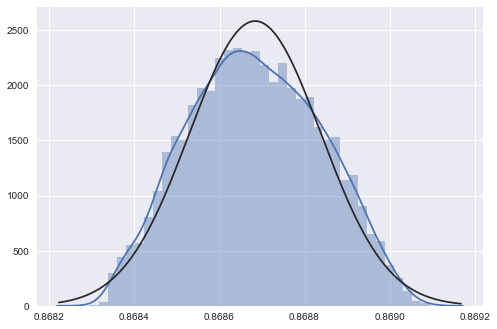

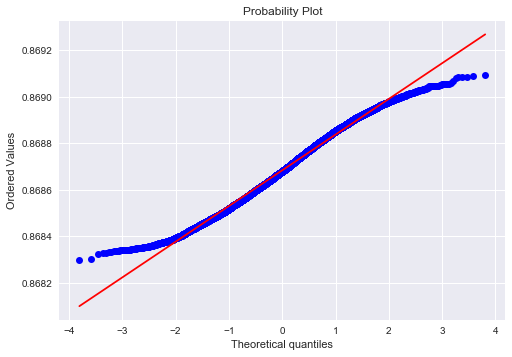

In [14]:
from scipy.stats import boxcox
from scipy.special import inv_boxcox

bc_Y, maxlog = boxcox(train_set['NU_NOTA_MT'].values)

model_bc = LinearRegression(normalize=True)
model_bc = model_bc.fit(X=train_X, y=bc_Y)
Y = inv_boxcox(model_bc.predict(train_X), maxlog)

print('MAPE: %.4f'%mape(y_true=train_Y, y_pred=Y))
plot_dist(bc_Y)

answer_bc = answer.copy()
answer_bc.loc[test_X.index, 'NU_NOTA_MT'] = inv_boxcox(model_bc.predict(test_X), maxlog)
answer_bc = answer_bc.sort_values(by='NU_NOTA_MT',ascending=False).reset_index()
# New app not configured
# send_answer(answer_bc, 2)

<h3><a href="http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.QuantileTransformer.html">QuantileTransformer</a></h3>
<br><a href="https://en.wikipedia.org/wiki/Data_transformation_(statistics)">_Rank transformer_</a><br>


MAPE: 0.1211


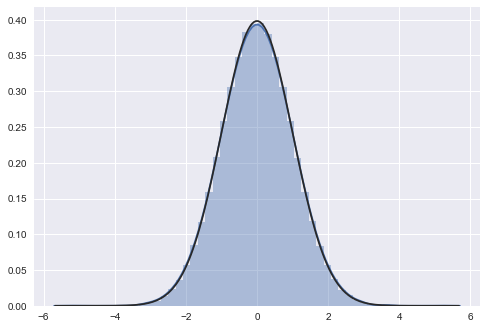

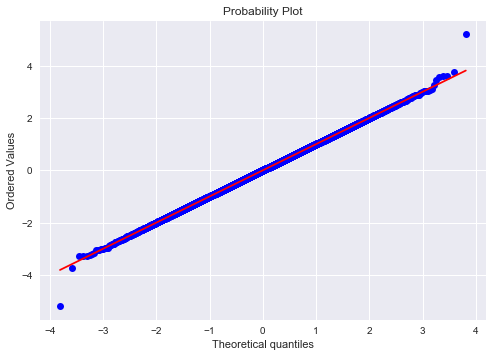

In [15]:
n_quantiles = 1500

from sklearn.preprocessing import QuantileTransformer, quantile_transform

plot_dist(quantile_transform(train_Y.to_frame(), n_quantiles=n_quantiles, output_distribution='normal')[:,0])

qt = {
    'X': QuantileTransformer(n_quantiles=n_quantiles, output_distribution='normal'),
    'Y': QuantileTransformer(n_quantiles=n_quantiles, output_distribution='normal')
}

qt_train_X = pd.DataFrame(qt['X'].fit_transform(train_X.values))
qt_Y = qt['Y'].fit_transform(train_Y.to_frame())
qt_shape = qt_Y.shape

model_qt = LinearRegression(normalize=True)
model_qt.fit(qt_train_X, qt_Y.reshape((1,qt_Y.shape[0]))[0])
Y_pred = qt['Y'].inverse_transform(model_qt.predict(qt_train_X).reshape(qt_shape)).reshape(1,qt_shape[0])[0]
print('MAPE: %.4f'%mape(y_true=train_Y, y_pred=Y_pred))

# test-set

qt_test_X = pd.DataFrame(qt['X'].transform(test_X.values))
prediction = qt['Y'].inverse_transform(model_qt.predict(qt_test_X).reshape((test_X.shape[0],1))).reshape(1,test_X.shape[0])[0]

# send answers
answer_qt = answer.copy()
answer_qt.loc[test_X.index, 'NU_NOTA_MT'] = prediction
answer_qt = answer_qt.sort_values(by='NU_NOTA_MT',ascending=False).reset_index()

# New app not configured
# send_answer(answer_qt, 2)